## Modeling Exercises

1.Select a dataset with a continuous target variable.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

from pydataset import data

In [2]:
df = data('swiss')
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [3]:
df.shape

(47, 6)

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [5]:
def split(df):
    '''
    This function take in the telco data acquired by get_telco_data,
    performs a split and stratifies churn column.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test

In [6]:
train, validate, test = split(df)

In [7]:
target = 'Fertility'

X_train, y_train = train.drop(columns= ['Fertility']), train[target]
X_validate, y_validate = validate.drop(columns= ['Fertility']), validate[target]
X_test, y_test = test.drop(columns= ['Fertility']), test[target]

In [8]:
numeric_cols= ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

In [9]:
#scaling using a function that makes minmax scaler

def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    """
    this function takes in 3 dataframes with the same columns,
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler.
    it returns 3 dataframes with the same column names and scaled values.
    """
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).

    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    # scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train.
    #
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=numeric_cols).set_index(
        [X_train.index.values]
    )

    X_validate_scaled = pd.DataFrame(
        X_validate_scaled_array, columns=numeric_cols
    ).set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=numeric_cols).set_index(
        [X_test.index.values]
    )

    return X_train_scaled, X_validate_scaled, X_test_scaled

In [10]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [11]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((25, 5), (12, 5), (10, 5))

In [12]:
X_train_scaled.head()

,Agriculture,Examination,Education,Catholic,Infant.Mortality
Rolle,0.647561,0.40625,0.290323,0.054508,0.122449
Lavaux,0.796341,0.50000,0.258065,0.004508,0.500000
Nyone,0.526829,0.59375,0.354839,0.130533,0.163265
Conthey,0.953659,0.00000,0.032258,0.997029,0.000000
Yverdon,0.509756,0.37500,0.225806,0.037910,0.755102


3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [13]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(score_func=f_regression, k=2)
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fa63a572700>)

In [14]:
X_train_scaled.columns[f_selector.get_support()]

Index(['Examination', 'Catholic'], dtype='object')

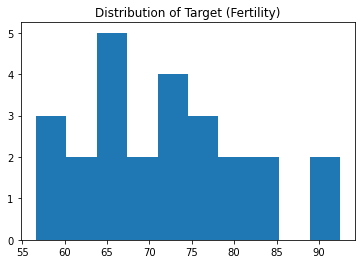

In [15]:
plt.hist(y_train)
plt.title('Distribution of Target (Fertility)')
plt.show()

In [16]:
y_train.head()

Rolle      60.5
Lavaux     65.1
Nyone      56.6
Conthey    75.5
Yverdon    65.4
Name: Fertility, dtype: float64

In [17]:
y_train = pd.DataFrame({'actual': y_train})

In [18]:
y_train.head()

,actual
Rolle,60.5
Lavaux,65.1
Nyone,56.6
Conthey,75.5
Yverdon,65.4


In [19]:
baseline = y_train.actual.mean()

In [20]:
y_train['baseline'] = baseline

In [21]:
y_train.head()

,actual,baseline
Rolle,60.5,71.536
Lavaux,65.1,71.536
Nyone,56.6,71.536
Conthey,75.5,71.536
Yverdon,65.4,71.536


In [22]:
print('Train RMSE Baseline model:')
math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

Train RMSE Baseline model:


9.773714953895475

In [23]:
# OLS -- ordinary least squares - way the coefficients are calculated
model2 = LinearRegression()
# When add additional values to y_train, we need to fit with a single column
model2.fit(X_train, y_train.actual)

LinearRegression()

In [24]:
y_train['model2'] = model2.predict(X_train)

In [25]:
y_train.head()

,actual,baseline,model2
Rolle,60.5,71.536,60.269929
Lavaux,65.1,71.536,62.787338
Nyone,56.6,71.536,58.254874
Conthey,75.5,71.536,73.350724
Yverdon,65.4,71.536,75.224245


In [26]:
print('Train RMSE for model2:')
math.sqrt(mean_squared_error(y_train.actual, y_train.model2))

Train RMSE for model2:


4.571043042889269

In [27]:
model3 = LassoLars(alpha=1)
model3.fit(X_train, y_train.actual)

LassoLars(alpha=1)

In [28]:
y_train['model3'] = model3.predict(X_train)

In [29]:
y_train.head()

,actual,baseline,model2,model3
Rolle,60.5,71.536,60.269929,70.375072
Lavaux,65.1,71.536,62.787338,70.216225
Nyone,56.6,71.536,58.254874,70.616599
Conthey,75.5,71.536,73.350724,73.369412
Yverdon,65.4,71.536,75.224245,70.322340


In [30]:
print('Train RMSE for model3:')
math.sqrt(mean_squared_error(y_train.actual, y_train.model3))

Train RMSE for model3:


8.900787755452747

In [31]:
# different from our other models in that this just transforms the X
# *after* the polynomial transformation, run the transformed data through the same model(s)
X_train_poly = X_train[['Examination', 'Catholic']]

poly = PolynomialFeatures()
poly.fit(X_train_poly)
X_transformed = poly.transform(X_train_poly)

In [32]:
pd.DataFrame(X_transformed, columns=poly.get_feature_names(input_features=X_train_poly.columns)).head(3)

,1,Examination,Catholic,Examination^2,Examination Catholic,Catholic^2
0,1.0,16.0,7.72,256.0,123.52,59.5984
1,1.0,19.0,2.84,361.0,53.96,8.0656
2,1.0,22.0,15.14,484.0,333.08,229.2196


In [33]:
model4 = LinearRegression()
model4.fit(X_transformed, y_train.actual)

LinearRegression()

In [34]:
y_train['model4'] = model4.predict(X_transformed)
y_train.head()

,actual,baseline,model2,model3,model4
Rolle,60.5,71.536,60.269929,70.375072,67.636580
Lavaux,65.1,71.536,62.787338,70.216225,64.301643
Nyone,56.6,71.536,58.254874,70.616599,66.024719
Conthey,75.5,71.536,73.350724,73.369412,77.984669
Yverdon,65.4,71.536,75.224245,70.322340,68.039111


In [35]:
print('Train RMSE for model4:')
math.sqrt(mean_squared_error(y_train.actual, y_train.model4))

Train RMSE for model4:


6.761223367006051

In [36]:
y_validate = pd.DataFrame({'actual': y_validate})
y_validate.head()

,actual
Moudon,65.0
Echallens,68.3
Moutier,85.8
Morges,65.5
Sierre,92.2


In [37]:
X_validate_poly = X_validate[['Examination', 'Catholic']]
X_validate_transformed = poly.transform(X_validate_poly)

In [38]:
y_validate['baseline'] = y_train.actual.mean()
y_validate['model2'] = model2.predict(X_validate)
y_validate['model3'] = model3.predict(X_validate)
y_validate['model4'] = model4.predict(X_validate_transformed)

In [39]:
y_validate.head()

,actual,baseline,model2,model3,model4
Moudon,65.0,71.536,75.551909,70.270910,68.519490
Echallens,68.3,71.536,68.967459,70.911508,70.133816
Moutier,85.8,71.536,78.065280,71.223018,74.683361
Morges,65.5,71.536,58.758237,70.294021,63.076421
Sierre,92.2,71.536,75.725605,73.361275,78.006271


In [40]:
print('Train RMSE baseline:')
print(math.sqrt(mean_squared_error(y_train.actual, y_train.baseline)))

print('Train RMSE model2:')
print(math.sqrt(mean_squared_error(y_train.actual, y_train.model2)))

print('Train RMSE model3:')
print(math.sqrt(mean_squared_error(y_train.actual, y_train.model3)))

print('Train RMSE for model4:')
print(math.sqrt(mean_squared_error(y_train.actual, y_train.model4)))

Train RMSE baseline:
9.773714953895475
Train RMSE model2:
4.571043042889269
Train RMSE model3:
8.900787755452747
Train RMSE for model4:
6.761223367006051


In [41]:
print('Validate RMSE baseline:')
print(math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline)))

print('Validate RMSE model2:')
print(math.sqrt(mean_squared_error(y_validate.actual, y_validate.model2)))

print('Validate RMSE model3:')
print(math.sqrt(mean_squared_error(y_validate.actual, y_validate.model3)))

print('Validate RMSE model4:')
print(math.sqrt(mean_squared_error(y_validate.actual, y_validate.model4)))

Validate RMSE baseline:
14.781010204538344
Validate RMSE model2:
12.132738217927676
Validate RMSE model3:
14.583862842774936
Validate RMSE model4:
15.273427612223394


In [42]:
# model2 performs the best - evaluate on test!
print('Train RMSE model2:')
print(math.sqrt(mean_squared_error(y_train.actual, y_train.model2)))

print('Validate RMSE model2:')
print(math.sqrt(mean_squared_error(y_validate.actual, y_validate.model2)))

print('Test RMSE model2:')
print(math.sqrt(mean_squared_error(model2.predict(X_test), y_test)))

Train RMSE model2:
4.571043042889269
Validate RMSE model2:
12.132738217927676
Test RMSE model2:
10.679921011236853
